# 20152410 배형준 머신러닝 과제11

In [50]:
# library import

#nltk.download('stopwords')
#nltk.download('wordnet')

import numpy as np
import re # 정규 표현식 : regular expression
import nltk # 자연어 처리 : natural language toolkit
from sklearn.datasets import load_files # Load text files with categories as subfolder names.
import pickle # 텍스트가 아닌 자료형 불러오기 (ex. list, class etc)
from nltk.corpus import stopwords # 불용어를 추출하는 함수
from nltk.stem import WordNetLemmatizer # 표제어를 추출하는 함수, 기본 사전형 단어
from sklearn.feature_extraction.text import CountVectorizer
# 문서 집합에서 단어 토큰을 생성하고 각 단어의 수를 세어 BOW 인코딩한 벡터를 만든다.
from sklearn.feature_extraction.text import TfidfTransformer
# CountVectorizer와 비슷하지만 TF-IDF 방식으로 단어의 가중치를 조정한 BOW 벡터를 만든다. (단어 가중치를 tfidf 방식으로 조절)
from sklearn.model_selection import train_test_split # train, test 나눠주는 함수

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# 문자열 전처리

In [2]:
# load files

review_data = load_files(r"movie_review")
review_data

# 문자열 앞에 r을 붙히면 raw 문자열로 인식해서 \n, \t같은 escape가 안통함

{'data': [b'bad . bad . \nbad . \nthat one word seems to pretty much sums up beyond the valley of the dolls . \nif that summary isn\'t enough for you , how about t&a , t&a , t&a ? \nstill haven\'t got the point ? \nother than director russ meyer\'s predilection for casting attractive large breasted women who ultimately expose the afore-mentioned anatomical areas , there is really only one other reason to recommend even taking a look at this movie . \nthat is the fact that it was co-written by famed film critic roger ebert , who also was responsible for the screenplay . \nafter watching this movie you will never be able to sit through another one of his reviews where he gives a movie a thumbs down for bad writing with a straight face . \nthis movie stinks out loud . \nquite frankly , this movie deserves a . \nbut there are parts of it that are so bad they are almost funny . \nso i\'m giving it a . \nand maybe that is too generous . \nright from the opening credits , i knew that i had a 

In [3]:
# split data(review) and target(pos: 1, neg: 0)

X, y = review_data.data, review_data.target

In [4]:
# neg, pos 순으로 나와야 하니 확인

print(y[0], y[2])
print(review_data['filenames'][0], review_data['filenames'][2])

0 1
movie_review\neg\cv676_22202.txt movie_review\pos\cv238_12931.txt


re.sub 사용법

re.sub(pattern, repl, string) : string에서 pattern과 매치하는 텍스트를 repl로 치환한다

In [5]:
# 표제어 추출하기

documents = []

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen])) # \W를 빈칸으로 치환
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) # 문장 맨 앞에 A 같은거 제거
    
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)
    
    # Converting to Lowercase
    document = document.lower() # 소문자로 바꾸기
    
    # Lemmatization : 표제어 추출
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

# 0. Optimization

In [10]:
class penalized_neural_network:

    def __init__(self, learning_rate, error_bound, iteration, cutoff, random_state,
                 hidden_layer, number_node, fit_intercept, alpha):
        self.learning_rate = learning_rate
        self.error_bound = error_bound
        self.iteration = iteration
        self.cutoff = cutoff
        self.random_state = random_state
        self.alpha = alpha # penalized hyper parameter
        self.number_parameter = 0
        
        self.hidden_layer = hidden_layer # int
        self.number_node = number_node # list of int
        self.fit_intercept = fit_intercept # True or False
        
        self.record_train_cost = []
        self.record_test_cost = []
        self.record_train_accuracy = []
        self.record_test_accuracy = []
        
        self.coef_list = []
        self.train_predict = []
        self.test_predict = []
        self.last_gradient = []
    
    def sigmoid(self, X, coef):
        z = np.dot(X, coef)
        sigmoid_value = 1 / (1 + np.exp(-z))
        
        return sigmoid_value
    
    def cost(self, X, coef_list, onehot_label):
        delta = 10**(-8)
        m = X.shape[0]
        temp = X
        sigmoid_list = []
        
        # forward propagation
        for coef in coef_list:    
            sig = self.sigmoid(temp, coef)
            sigmoid_list.append(sig)
            
            if self.fit_intercept == True:
                temp = np.column_stack((np.ones((sig.shape[0], 1)), sig))
            else:
                temp = sig
        
        error_term = -np.mean(np.sum(onehot_label * np.log(sig + delta) + (1 - onehot_label) * np.log(1 - sig + delta), axis=1))
        
        temp = 0
        for coef in coef_list:
            temp = temp + np.sum(coef**2)
        
        l2_term = (self.alpha * temp) / (2 * self.number_parameter)
        
        cost_value = error_term + l2_term
        
        return cost_value, sigmoid_list
    
    def gradient(self, X, coef_list, onehot_label, sigmoid_list):
        m = X.shape[0]
        delta_list = []
        gradient_list = []
        
        add_constant_sigmoid = []
        
        for i in range(len(sigmoid_list)):
            temp = np.column_stack((np.ones((sigmoid_list[i].shape[0], 1)), sigmoid_list[i]))
            add_constant_sigmoid.append(temp)
        
        sigmoid_list.insert(0, X)
        add_constant_sigmoid.insert(0, X)
        
        # backward propagation
        for i in range(self.hidden_layer+1):
            if i == 0:
                delta_value = sigmoid_list[-1] - onehot_label
                penarlized_term = self.alpha * coef_list[-1] / self.number_parameter
                gradient_value = np.dot(add_constant_sigmoid[-2].T, delta_value) / m + penarlized_term
                
                delta_list.insert(0, delta_value)
                gradient_list.insert(0, gradient_value)
            
            else:
                delta_value = np.dot(delta_list[0], coef_list[-i][1:, :].T) * sigmoid_list[-i-1] * (1 - sigmoid_list[-i-1])
                penarlized_term = self.alpha * coef_list[-i-1] / self.number_parameter
                gradient_value = np.dot(add_constant_sigmoid[-i-2].T, delta_value) / m + penarlized_term
                
                delta_list.insert(0, delta_value)
                gradient_list.insert(0, gradient_value)
        
        return gradient_list
    
    def predict(self, sigmoid_list, predict_type='class'):
        output_layer = sigmoid_list[-1]
        
        if predict_type == 'class':
            predict_value = np.where(output_layer.reshape(-1, 1) >= self.cutoff, 1, 0)
            # softmax가 아니고 binary response니까 그거에 맞춰 수정해줌
        
        elif predict_type == 'response':
            predict_value = output_layer
        
        return predict_value
    
    def fit(self, X_train, Y_train, X_test, Y_test): # Y_train, Y_test는 onehotencoding이 완료된 데이터
        X_train = np.array(X_train)
        Y_train = np.array(Y_train)
        X_test = np.array(X_test)
        Y_test = np.array(Y_test)
        m = X_train.shape[0]
        n = X_train.shape[1]
        q = X_test.shape[0]
        p = Y_train.shape[1]
        
        self.number_node.insert(0, n)
        self.number_node.append(p)
        coef_list = []
        
        # fit_intercept
        if self.fit_intercept == True:
            number_node_with_intercept = []
            
            X_train = np.column_stack((np.ones((m, 1)), X_train))
            X_test = np.column_stack((np.ones((q, 1)), X_test))
            
            for number in self.number_node:
                number_node_with_intercept.append(number+1)
                
        else:
            number_node_with_intercept = self.number_node
        
        # calculate number of parameters
        number_parameter = 0
        for i in range(len(number_node_with_intercept)-1):
            temp = number_node_with_intercept[i]*number_node_with_intercept[i+1]
            number_parameter = number_parameter + temp
            
        self.number_parameter = number_parameter
        
        # set initial parameters
        np.random.seed(self.random_state) # for reproducibility
        
        for layer in range(self.hidden_layer+1):
            temp_theta = np.random.randn(number_node_with_intercept[layer], self.number_node[layer+1])
            coef_list.append(temp_theta)
        
        # check model fitting progress
        import time
        start = time.time()
        
        # model fitting
        while True:
            # calculate train and test cost
            train_cost, train_sigmoid = self.cost(X_train, coef_list, Y_train)
            test_cost, test_sigmoid = self.cost(X_test, coef_list, Y_test)
            
            self.record_train_cost.append(train_cost)
            self.record_test_cost.append(test_cost)
            
            # calculate train and test accuracy
            train_predict = self.predict(train_sigmoid, predict_type='class').reshape(-1, 1)
            test_predict = self.predict(test_sigmoid, predict_type='class').reshape(-1, 1)
            
            train_accuarcy = np.mean(train_predict == Y_train)
            test_accuarcy = np.mean(test_predict == Y_test)
            
            self.record_train_accuracy.append(train_accuarcy)
            self.record_test_accuracy.append(test_accuarcy)
            
            # calculate gradient using back propagation and renew the parameters
            gradient_list = self.gradient(X_train, coef_list, Y_train, train_sigmoid)
            
            for i in range(len(coef_list)):
                coef_list[i] = coef_list[i] - self.learning_rate * gradient_list[i]

            # stopping rules
            length = len(self.record_train_accuracy)
            
            if length > self.iteration:
                if self.record_train_accuracy[-2] - self.record_train_accuracy[-1] < self.error_bound:
                    break
            
            # print model fitting progress
            running_time = time.time() - start
            minute = int(running_time // 60)
            second = round(running_time % 60, 1)
            
            if length % 500 == 0:
                print('Iter : {}, Running time : {}m {}s'.format(length, minute, second), end=', ')
                print('Train accuracy : {}%, Test accuracy : {}%'.format(round(100*train_accuarcy, 4),
                                                                         round(100*test_accuarcy, 4)))
                print('Train Cost : {}, Test Cost : {}\n'.format(train_cost, test_cost))
            
            # error situation : too much iteration
            if length > 10000:
                print('반복 횟수가 너무 많습니다. Train Cost가 수렴하지 못했습니다. 학습률을 조정해보시기 바랍니다.')
                break
                
        self.coef_list = coef_list
        self.train_predict = train_predict
        self.test_predict = test_predict
        self.last_gradient = gradient_list
        
        return self

# 모델링을 위한 데이터 준비

max_df : float in range [0.0, 1.0] or int, default=1.0

When building the vocabulary ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

어떤 단어가 너무 많이 나온다 => 의미 없을 가능성이 있음 => 너무 많이 출몰하는 단어 제거

min_df : float in range [0.0, 1.0] or int, default=1

When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

어떤 단어가 너무 적게 나온다 => 의미 없을 가능성이 있음 => 너무 적게 출몰하는 단어 제거

모델링의 결과를 통해 조정해야되는 하이퍼 파라미터로 보고 진행해야겠다.

In [274]:
vectorizer = CountVectorizer(max_features=1500, min_df=10, max_df=1.0, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

# 학습용 데이터와 테스트용 데이터 분리

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [275]:
high_frequency = pd.DataFrame(vectorizer.vocabulary_.values(), index=vectorizer.vocabulary_.keys(), columns=['freq'])
high_frequency.sort_values(by='freq', ascending=False).head(10)

,freq
younger,1499
young,1498
york,1497
yet,1496
yes,1495
year,1494
wrote,1493
wrong,1492
written,1491
writing,1490


In [276]:
low_frequency = pd.DataFrame(vectorizer.vocabulary_.values(), index=vectorizer.vocabulary_.keys(), columns=['freq'])
low_frequency.sort_values(by='freq', ascending=True).head(10)

,freq
000,0
10,1
13,2
1997,3
1998,4
1999,5
20,6
80,7
90,8
ability,9


In [278]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1401, 1500) (601, 1500) (1401, 1) (601, 1)


In [279]:
model_neural_network = penalized_neural_network(error_bound=10**(-7),
                                                random_state=20152410,
                                                fit_intercept=True,
                                                iteration=3000,
                                                cutoff=0.5,
                                                learning_rate=25,
                                                hidden_layer=1,
                                                number_node=[400],
                                                alpha=0)

In [280]:
model_neural_network.fit(X_train=X_train,
                         Y_train=y_train,
                         X_test=X_test,
                         Y_test=y_test)

Iter : 500, Running time : 1m 54.3s, Train accuracy : 52.9622%, Test accuracy : 51.0815%
Train Cost : 2.604901860536686, Test Cost : 3.3507664815687637

Iter : 1000, Running time : 4m 9.9s, Train accuracy : 100.0%, Test accuracy : 81.6972%
Train Cost : 0.001915111402054665, Test Cost : 1.018464789877029

Iter : 1500, Running time : 6m 21.8s, Train accuracy : 100.0%, Test accuracy : 81.0316%
Train Cost : 0.000600150520427759, Test Cost : 1.1551851985722232

Iter : 2000, Running time : 8m 40.6s, Train accuracy : 100.0%, Test accuracy : 80.8652%
Train Cost : 0.0003376587444168498, Test Cost : 1.2231528968377632

Iter : 2500, Running time : 10m 54.2s, Train accuracy : 100.0%, Test accuracy : 81.198%
Train Cost : 0.00023023742090851895, Test Cost : 1.2674294373261978

Iter : 3000, Running time : 13m 10.6s, Train accuracy : 100.0%, Test accuracy : 81.0316%
Train Cost : 0.00017278721049378463, Test Cost : 1.2998864638229037



In [281]:
100*np.max(model_neural_network.record_test_accuracy)

81.86356073211314

# Result record

## 1. hidden_layer=1로 고정했을 때 number_node 찾기

1. min_df=0, max_df=1.0, iteration=1000, cutoff = 0.5, learning_rate=5, hidden_layer=1, number_node=[100], alpha=0

Iter : 1000, Running time : 1m 26.5s, Train accuracy : 100.0%, Test accuracy : 78.5358%
Train Cost : 0.018888623541087928, Test Cost : 0.6847944452077148

2. min_df=0, max_df=1.0, iteration=2000, cutoff = 0.5, learning_rate=5, hidden_layer=1, number_node=[200], alpha=0

Iter : 2000, Running time : 4m 7.9s, Train accuracy : 100.0%, Test accuracy : 80.6988%
Train Cost : 0.003273068768531321, Test Cost : 0.8549383805668753

3. min_df=0, max_df=1.0, iteration=2000, cutoff = 0.5, learning_rate=10, hidden_layer=1, number_node=[300], alpha=0

Iter : 2000, Running time : 6m 6.6s, Train accuracy : 100.0%, Test accuracy : 80.8652%
Train Cost : 0.0011648483645883704, Test Cost : 0.7992529635640191

4. min_df=0, max_df=1.0, iteration=2000, cutoff = 0.5, learning_rate=20, hidden_layer=1, number_node=[400], alpha=0

Iter : 2000, Running time : 8m 13.3s, Train accuracy : 100.0%, Test accuracy : 82.5291%
Train Cost : 0.0004302239914602246, Test Cost : 1.157898729877365

5. min_df=0, max_df=1.0, iteration=2000, cutoff = 0.5, learning_rate=25, hidden_layer=1, number_node=[500], alpha=0

Iter : 2000, Running time : 9m 6.7s, Train accuracy : 100.0%, Test accuracy : 82.03%
Train Cost : 0.00035090657084263846, Test Cost : 1.2530943586022487

6. min_df=0, max_df=1.0, iteration=2000, cutoff = 0.5, learning_rate=50, hidden_layer=1, number_node=[600], alpha=0

Iter : 2000, Running time : 9m 57.3s, Train accuracy : 59.3862%, Test accuracy : 57.7371%
Train Cost : 6.131301355851415, Test Cost : 6.426614378905849

learning_rate=50 이건 너무 높았나보다

7. min_df=0, max_df=1.0, iteration=2000, cutoff = 0.5, learning_rate=30, hidden_layer=1, number_node=[600], alpha=0

Iter : 2000, Running time : 10m 5.9s, Train accuracy : 100.0%, Test accuracy : 81.6972%
Train Cost : 0.00036237219823631204, Test Cost : 1.193715461419355

8. min_df=0, max_df=1.0, iteration=2000, cutoff = 0.5, learning_rate=30, hidden_layer=1, number_node=[1000], alpha=0

Iter : 2000, Running time : 16m 57.0s, Train accuracy : 100.0%, Test accuracy : 80.6988%
Train Cost : 0.00022387930416110048, Test Cost : 1.184035323221805

9. min_df=0, max_df=1.0, iteration=2000, cutoff = 0.5, learning_rate=30, hidden_layer=1, number_node=[450], alpha=0

Iter : 2000, Running time : 7m 51.8s, Train accuracy : 100.0%, Test accuracy : 81.8636%
Train Cost : 0.00047805556151478385, Test Cost : 1.3024161857712617

10. min_df=0, max_df=1.0, iteration=2000, cutoff = 0.5, learning_rate=30, hidden_layer=1, number_node=[400], alpha=0

Iter : 2000, Running time : 7m 25.6s, Train accuracy : 100.0%, Test accuracy : 80.8652%
Train Cost : 0.0003376587444168498, Test Cost : 1.2231528968377632

## 2. number_node=[400]으로 고정하고 min_df, max_df 찾기

11. min_df=5, max_df=1.0, iteration=3000, cutoff = 0.5, learning_rate=25, hidden_layer=1, number_node=[400], alpha=0

Iter : 3000, Running time : 10m 22.2s, Train accuracy : 100.0%, Test accuracy : 82.03%
Train Cost : 0.5151579347485435, Test Cost : 1.3025845489846843

12. min_df=10, max_df=1.0, iteration=3000, cutoff = 0.5, learning_rate=25, hidden_layer=1, number_node=[400], alpha=0

Iter : 3000, Running time : 10m 39.2s, Train accuracy : 100.0%, Test accuracy : 83.3611%
Train Cost : 0.6823002419622102, Test Cost : 1.6602314723675078

최댓값 : 85.19134775374376%

## 3. min_df=150, max_df=0.7로 하니까 number_node를 다시 찾아야되네... 순서 잘못했다.

13. min_df=150, max_df=0.7, iteration=3000, cutoff = 0.5, learning_rate=25, hidden_layer=1, number_node=[300], alpha=0

Iter : 3000, Running time : 4m 38.5s, Train accuracy : 96.6453%, Test accuracy : 80.0333%
Train Cost : 0.7942382406192481, Test Cost : 1.3622694591813125

진동함

14. min_df=150, max_df=0.7, iteration=3000, cutoff = 0.5, learning_rate=10, hidden_layer=1, number_node=[300], alpha=0

Iter : 3000, Running time : 4m 37.7s, Train accuracy : 82.0128%, Test accuracy : 74.5424%
Train Cost : 0.8441115215804635, Test Cost : 1.3552755885603216

진동함

15. min_df=150, max_df=0.7, iteration=3000, cutoff = 0.5, learning_rate=5, hidden_layer=1, number_node=[300], alpha=0

Iter : 3000, Running time : 4m 38.3s, Train accuracy : 99.8572%, Test accuracy : 80.0333%
Train Cost : 1.2921739432365236, Test Cost : 1.7678417017344752

진동함

굳이 발산하는 조합에서 하지말고 원래 하던대로 가자

## 4. min_df=0, max_df=1.0, number_node=[400]하고 alpha 찾기

16. min_df=0, max_df=1.0, iteration=3000, cutoff = 0.5, learning_rate=30, hidden_layer=1, number_node=[400], alpha=0

50에서 시작해서 점점 내려가며 찾자

Iter : 3000, Running time : 13m 10.6s, Train accuracy : 100.0%, Test accuracy : 81.0316%
Train Cost : 0.00017278721049378463, Test Cost : 1.2998864638229037

17. min_df=10, max_df=1.0, iteration=3000, cutoff=0.5, learning_rate=25, hidden_layer=1, number_node=[400], alpha=10




# 1. Plot the loss curve

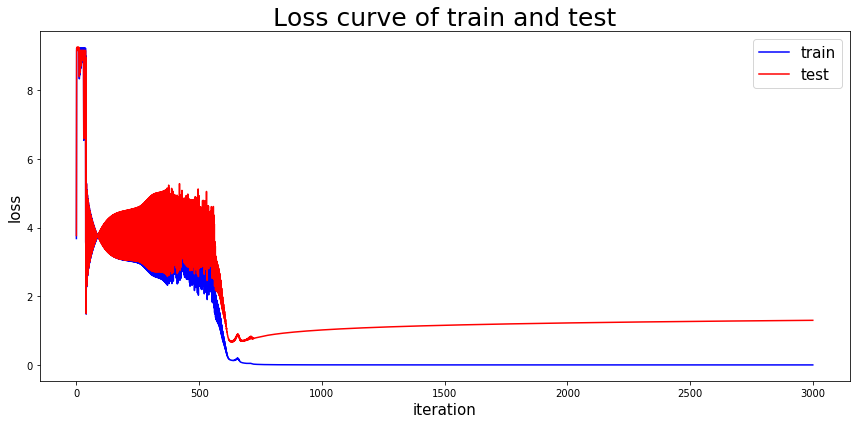

In [282]:
traincost = model_neural_network.record_train_cost
testcost = model_neural_network.record_test_cost

plt.figure(figsize=(12, 6))
plt.plot(traincost, 'b', label='train')
plt.plot(testcost, 'r', label='test')
plt.title('Loss curve of train and test', fontsize=25)
plt.xlabel('iteration', fontsize=15)
plt.ylabel('loss', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()

# 2. Plot the accuracy curve

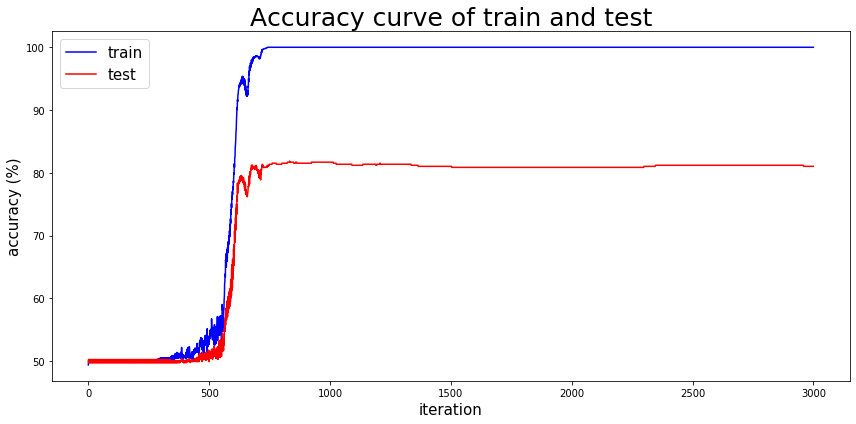

In [283]:
trainacc100 = 100*np.array(model_neural_network.record_train_accuracy)
testacc100 = 100*np.array(model_neural_network.record_test_accuracy)

plt.figure(figsize=(12, 6))
plt.plot(trainacc100, 'b', label='train')
plt.plot(testacc100, 'r', label='test')
plt.title('Accuracy curve of train and test', fontsize=25)
plt.xlabel('iteration', fontsize=15)
plt.ylabel('accuracy (%)', fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.tight_layout()
plt.show()

# 3. Plot the quantitative results

In [284]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

traina = trainacc100[-1]
trainb = traincost[-1]

print(confusion_matrix(y_train, model_neural_network.train_predict), '\n')
print(classification_report(y_train, model_neural_network.train_predict), '\n')
print('Final train accuracy : {}%, Final train loss : {}'.format(traina, trainb))

[[699   0]
 [  0 702]] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       699
           1       1.00      1.00      1.00       702

    accuracy                           1.00      1401
   macro avg       1.00      1.00      1.00      1401
weighted avg       1.00      1.00      1.00      1401
 

Final train accuracy : 100.0%, Final train loss : 0.0001726994388612751


In [285]:
testa = testacc100[-1]
testb = testcost[-1]

print(confusion_matrix(y_test, model_neural_network.test_predict), '\n')
print(classification_report(y_test, model_neural_network.test_predict), '\n')
print('Final test accuracy : {}%, Final test loss : {}'.format(testa, testb))

[[235  67]
 [ 47 252]] 

              precision    recall  f1-score   support

           0       0.83      0.78      0.80       302
           1       0.79      0.84      0.82       299

    accuracy                           0.81       601
   macro avg       0.81      0.81      0.81       601
weighted avg       0.81      0.81      0.81       601
 

Final test accuracy : 81.03161397670549%, Final test loss : 1.299943369943905
